In [2]:
%matplotlib inline

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [92]:
from sklearn.metrics import f1_score

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#### Helper functions

In [108]:
cut_dict = {
    'Fair' : 0,
    'Very Good' : 1,
    'Good' : 2,
    'Premium' : 3,
    'Ideal' : 4
}
color_dict = {y:x for x, y in cut_dict.items()}

def show_scoring_results(clasification_type, model):
    print(f"{clasification_type} F1 micro train score: {f1_score(diamonds_labelss_train, model.predict(diamonds_features_train), average = 'micro')}")
    print(f"{clasification_type} F1 micro train score: {f1_score(diamonds_labelss_test, model.predict(diamonds_features_test), average = 'micro')}")


def plot_confusion_matrix(estimator, features, labels, title = None):
    predictions = estimator.predict(features)
    cm = confusion_matrix(labels, predictions, normalize = "all")
    plt.figure(figsize = (10, 10))
    if title is not None:
        plt.title(label = title)
    sns.heatmap(
        cm ,
        annot = True,
        fmt = ".2%",
        cmap = plt.cm.Blues,
        xticklabels = np.array([color_dict[val] for val in estimator.classes_]),
        yticklabels = np.array([color_dict[val] for val in estimator.classes_])
    )
    plt.show()

# 1. Abstract

The task of this paper will be to compare five classification algorithms.

The Algorithms that will be subject of the paper are: Logistic Regression, Decision Tree, Random Foresr, Gausian SVM and Linear SVM.

The data set that will be used is call **diamonds**, dataset contains the prices and other attributes of almost 54,000 diamonds.

Within this task I will try to find out what is the **cut quality** of any given diamond depending on the other features 

# 2. Data Reading
#### 2.1) Retirve Data

In [114]:
diamonds_data = pd.read_csv("data/diamonds.csv")
diamonds_data.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


#### 2.2) Features Explanation
* **Carat**: Carat weight of the Diamond.
* **Cut**: Describe cut quality of the diamond
    + Quality in increasing order Fair, Good, Very Good, Premium, Ideal.
* **Color **:  Color of the Diamond.
    + With D being the best and J the worst.
* **Clarity**: Diamond Clarity refers to the absence of the Inclusions and Blemishes.
    + (In order from Best to Worst, FL = flawless, I3= level 3 inclusions) FL, IF, VVS1, VVS2, VS1, VS2, SI1, SI2, I1, I2, I3
* **Depth**: The Height of a Diamond, measured from the Culet to the table, divided by its average Girdle Diameter. 
    + depth total depth percentage = z / mean(x, y) = 2 * z / (x + y)
* **Table**: The Width of the Diamond's Table expressed as a Percentage of its Average Diameter. 
    + table width of top of diamond relative to widest point
* **Price**: the Price of the Diamond.
* **X**: Length of the Diamond in mm.
* **Y**: Width of the Diamond in mm.
* **Z**: Height of the Diamond in mm.

Qualitative Features (Categorical) : Cut, Color, Clarity.

Quantitative Features (Numerical) : Carat, Depth , Table , Price , X , Y, Z.

In [6]:
diamonds_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  53940 non-null  int64  
 1   carat       53940 non-null  float64
 2   cut         53940 non-null  object 
 3   color       53940 non-null  object 
 4   clarity     53940 non-null  object 
 5   depth       53940 non-null  float64
 6   table       53940 non-null  float64
 7   price       53940 non-null  int64  
 8   x           53940 non-null  float64
 9   y           53940 non-null  float64
 10  z           53940 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 4.5+ MB


#### 2.3) Remove index column that will not be needed

In [115]:
diamonds_data = diamonds_data.drop("Unnamed: 0", axis = 1)

#### 2.4) Describe and analyze all the non-categorial values in he data set

We can see that there is zero values in dimentions column which is a sign for missing data, because no diamond can have zero dimention

In this situation I will examin the dataset and if there are few samples with missing dimentions will delete tham

In [116]:
diamonds_data.describe().T

,count,mean,std,min,25%,50%,75%,max
carat,53940.0,0.797940,0.474011,0.2,0.40,0.70,1.04,5.01
depth,53940.0,61.749405,1.432621,43.0,61.00,61.80,62.50,79.00
table,53940.0,57.457184,2.234491,43.0,56.00,57.00,59.00,95.00
price,53940.0,3932.799722,3989.439738,326.0,950.00,2401.00,5324.25,18823.00
x,53940.0,5.731157,1.121761,0.0,4.71,5.70,6.54,10.74
y,53940.0,5.734526,1.142135,0.0,4.72,5.71,6.54,58.90
z,53940.0,3.538734,0.705699,0.0,2.91,3.53,4.04,31.80


In [117]:
diamonds_data.shape

(53940, 10)

In [10]:
diamonds_data.loc[(diamonds_data["x"]==0) | (diamonds_data["y"]==0) | (diamonds_data["z"]==0)].shape

(20, 10)

I will delete the lines that have zero in any dimention feature

In [11]:
diamonds_data = diamonds_data[(diamonds_data[["x","y","z"]] != 0).all(axis =1)]
diamonds_data.shape

(53920, 10)

From correlation data we can conclude:
* **Depth is inversely related to Price.**
    + This is because if a Diamond's Depth percentage is too large or small the Diamond will become 'Dark' in appearance because it will no longer return an Attractive amount of light.
* **The Price of the Diamond is highly correlated to Carat, and its Dimensions.**

* **The Weight (Carat) of a diamond has the most significant impact on its Price.**
    + Since, the larger a stone is, the Rarer it is, one 2 carat diamond will be more 'Expensive' than the total cost of two 1 Carat Diamonds of the same Quality.
* **The Length(x) , Width(y) and Height(z) seems to be higly related to Price and even each other.**

In [12]:
diamonds_data.corr()

,carat,depth,table,price,x,y,z
carat,1.000000,0.028259,0.181646,0.921592,0.977779,0.953991,0.961048
depth,0.028259,1.000000,-0.295733,-0.010729,-0.025017,-0.029069,0.095023
table,0.181646,-0.295733,1.000000,0.127245,0.196097,0.184493,0.152483
price,0.921592,-0.010729,0.127245,1.000000,0.887231,0.867864,0.868206
x,0.977779,-0.025017,0.196097,0.887231,1.000000,0.974918,0.975435
y,0.953991,-0.029069,0.184493,0.867864,0.974918,1.000000,0.956744
z,0.961048,0.095023,0.152483,0.868206,0.975435,0.956744,1.000000


#### 2.5)  Label feature - Cut  values has to be changed with numeric one 

In [13]:
colors = diamonds_data["cut"].replace(cut_dict)

In [14]:
colors.shape

(53920,)

#### 2.6) Data visualizatrion

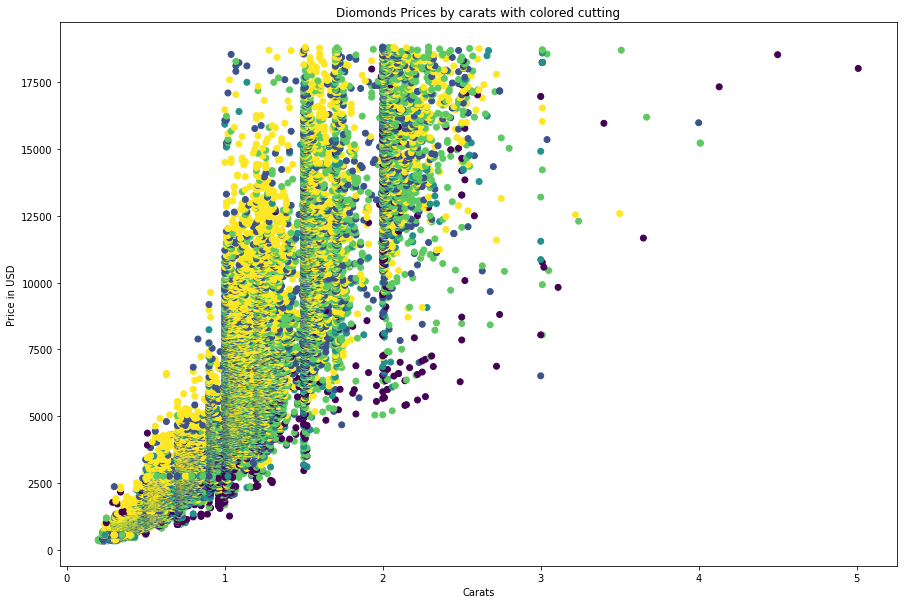

In [15]:
plt.figure(figsize=(15,10))
plt.scatter(diamonds_data["carat"], diamonds_data["price"], c = colors)
plt.xlabel("Carats")
plt.ylabel("Price in USD")
plt.title("Diomonds Prices by carats with colored cutting")
plt.show()

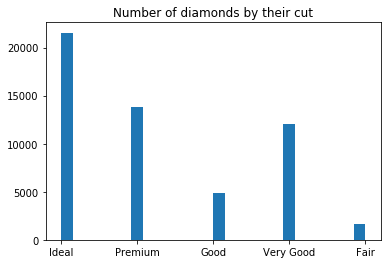

In [16]:
plt.hist(diamonds_data["cut"], bins = "fd")
plt.title("Number of diamonds by their cut")
plt.show()

# 3. Features engineering
#### 3.1) Devide labels and features 

In [17]:
diamonds_labels = colors.astype("int64")
diamonds_features = diamonds_data.drop("cut", axis = 1)

In [18]:
print(diamonds_labels.shape)
print(diamonds_features.shape)

(53920,)
(53920, 9)


In [19]:
diamonds_features.head()

,carat,color,clarity,depth,table,price,x,y,z
0,0.23,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,J,SI2,63.3,58.0,335,4.34,4.35,2.75


#### 3.2) Convert categorial columns to dummies

In [20]:
diamonds_features = pd.get_dummies(diamonds_features)
diamonds_features.shape

(53920, 22)

In [21]:
diamonds_features.head()

,carat,depth,table,price,x,y,z,color_D,color_E,color_F,...,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.23,61.5,55.0,326,3.95,3.98,2.43,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1,0.21,59.8,61.0,326,3.89,3.84,2.31,0,1,0,...,0,0,0,0,1,0,0,0,0,0
2,0.23,56.9,65.0,327,4.05,4.07,2.31,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,0.29,62.4,58.0,334,4.20,4.23,2.63,0,0,0,...,1,0,0,0,0,0,0,1,0,0
4,0.31,63.3,58.0,335,4.34,4.35,2.75,0,0,0,...,0,1,0,0,0,1,0,0,0,0


#### 3.3) Normalize data

In [22]:
scale = StandardScaler()
diamonds_features[['carat', 'depth', 'table', 'price', 'x', 'y', 'z']] = scale.fit_transform(diamonds_features[['carat', 'depth', 'table', 'price', 'x', 'y', 'z']])
diamonds_features.head()

,carat,depth,table,price,x,y,z,color_D,color_E,color_F,...,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,-1.198204,-0.174203,-1.099725,-0.904132,-1.591573,-1.539219,-1.580084,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1,-1.240417,-1.361090,1.585988,-0.904132,-1.645173,-1.662014,-1.750896,0,1,0,...,0,0,0,0,1,0,0,0,0,0
2,-1.198204,-3.385781,3.376463,-0.903881,-1.502241,-1.460280,-1.750896,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,-1.071566,0.454149,0.243131,-0.902125,-1.368242,-1.319943,-1.295396,0,0,0,...,1,0,0,0,0,0,0,1,0,0
4,-1.029353,1.082501,0.243131,-0.901875,-1.243176,-1.214690,-1.124583,0,0,0,...,0,1,0,0,0,1,0,0,0,0


In [23]:
diamonds_features[['carat', 'depth', 'table', 'price', 'x', 'y', 'z']].describe().T

,count,mean,std,min,25%,50%,75%,max
carat,53920.0,-2.289977e-14,1.000009,-1.261523,-0.839396,-0.206205,0.511411,8.890635
depth,53920.0,-2.795830e-15,1.000009,-13.090331,-0.523288,0.035248,0.523966,12.043756
table,53920.0,1.116263e-14,1.000009,-6.471152,-0.652106,-0.204488,0.690750,16.805029
price,53920.0,-4.567901e-15,1.000009,-0.904132,-0.747883,-0.383722,0.349178,3.734913
x,53920.0,1.150167e-15,1.000009,-1.788105,-0.912646,-0.028253,0.722141,4.474109
y,53920.0,-3.277413e-15,1.000009,-1.802350,-0.890162,-0.021829,0.706168,46.631351
z,53920.0,2.775953e-15,1.000009,-3.515961,-0.896833,-0.014300,0.711654,40.226327


#### 3.4) Split data to test and train sets


In [25]:
diamonds_features_train, diamonds_features_test,diamonds_labelss_train,diamonds_labelss_test = train_test_split(
    diamonds_features,
    diamonds_labels,
    train_size = 0.8,
    stratify = diamonds_labels)
diamonds_features_train.shape, diamonds_features_test.shape, diamonds_labelss_train.shape,diamonds_labelss_test.shape

((43136, 22), (10784, 22), (43136,), (10784,))

#### 3.5) Prepare the cross-validation fold

In [27]:
k_fold = StratifiedKFold(n_splits = 5)

# 4. Perform different classification approaches to data set

## 4.1) Logistic regression

The only parameter we will change in order to receive better results is C parameter. The parameter C is the the inverse of regularization strength in Logistic Regression.

#### Step 1

In [119]:
parameters = {
    "C": [1e-3,0.001,0.1,10, 100, 1000]
}
logistic_model = LogisticRegression()
grid_search = GridSearchCV(logistic_model, param_grid = parameters, scoring = "f1_micro", cv = k_fold)
grid_search.fit(diamonds_features_train, diamonds_labelss_train)
print("Logistic regression, best params", grid_search.best_params_)
print("Logistic regression; best score:", grid_search.best_score_)

Logistic regression, best params {'C': 1000}
Logistic regression; best score: 0.6529811044333165


#### Step 2

In [118]:
parameters = {
    "C": [500, 750, 1000, 1250, 1500, 2000]
}
logistic_model = LogisticRegression()
grid_search = GridSearchCV(logistic_model, param_grid = parameters, scoring = "f1_micro", cv = k_fold)
grid_search.fit(diamonds_features_train, diamonds_labelss_train)

print("Logistic regression; best score:", grid_search.best_score_)
print("Logistic regression, best params", grid_search.best_params_)

show_scoring_results("Logistic Regression", grid_search)

Logistic regression; best score: 0.6529811044333165
Logistic regression, best params {'C': 1000}
Logistic Regression F1 micro train score: 0.6534217359050445
Logistic Regression F1 micro train score: 0.656713649851632


We can see that there is no quality increase and even if we find the best value of teh C parameter the F1 metric will be hardy increase

Below we can observe the confusion matrix and classification report of Logistic Regression on test set

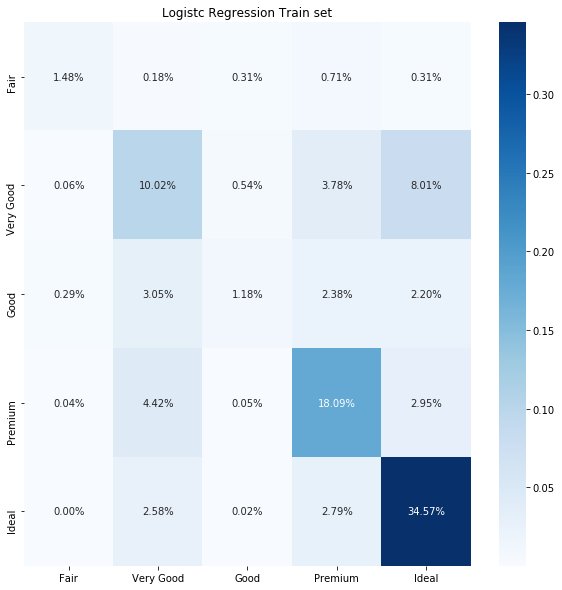

In [120]:
plot_confusion_matrix(grid_search, diamonds_features_train, diamonds_labelss_train, "Logistc Regression Train set")

In [122]:
print(classification_report(diamonds_labelss_test, grid_search.predict(diamonds_features_test)))

              precision    recall  f1-score   support

           0       0.73      0.43      0.54       322
           1       0.50      0.44      0.47      2416
           2       0.57      0.14      0.22       980
           3       0.67      0.73      0.70      2756
           4       0.72      0.86      0.78      4310

    accuracy                           0.66     10784
   macro avg       0.64      0.52      0.54     10784
weighted avg       0.64      0.66      0.63     10784



## 4.2) Decision Tree

Initially I will try to find the best parameters for most important parameters which are: max_depth and max_leaf_nodes and later will continue in narrow limits.

Desision tree parameters:
* **max_depth**: This indicates how deep the tree can be. The deeper the tree, the more splits it has and it captures more information about the data.
* **min_samples_split**: Represents the minimum number of samples required to split an internal node. This can vary between considering at least one sample at each node to considering all of the samples at each node. 
* **min_samples_leaf** The minimum number of samples required to be at a leaf node. This parameter is similar to min_samples_splits, however, this describe the minimum number of samples of samples at the leafs, the base of the tree.
* **max_leaf_nodes** Best nodes are defined as relative reduction in impurity. If None then unlimited number of leaf nodes.

In [65]:
parameters = {
    "max_depth":[1, 5, 7, 15, 20],
    "min_samples_leaf": [ 2, 5, 10, 12],
    "max_leaf_nodes": [5, 10, 20]
}
decision_tree_model = DecisionTreeClassifier()
grid_search = GridSearchCV(decision_tree_model, param_grid = parameters, scoring = "f1_micro", cv = k_fold)
grid_search.fit(diamonds_features_train, diamonds_labelss_train)
print("Decision tree, best params", grid_search.best_params_)
print("Decision Tree; best score:", grid_search.best_score_)

Decision tree, best params {'max_depth': 15, 'max_leaf_nodes': 20, 'min_samples_leaf': 2}
Decision Tree; best score: 0.7304802702687743


In [67]:
show_scoring_results("Decision Tree", grid_search)

Decision Tree train Accuracy: 0.7306889836795252
Decision Tree test Accuracy: 0.7275593471810089
Decision Tree F1 weighted train score: 0.7306889836795252
Decision Tree F1 weighted test score: 0.7275593471810089


Decision tree, best params {'max_depth': 12, 'max_leaf_nodes': 25, 'min_samples_leaf': 2, 'min_samples_split': 2}
Decision tree, best scoring 0.7331230631435555
Decision Tree F1 micro train score: 0.7350936572700297
Decision Tree F1 micro train score: 0.7293212166172107


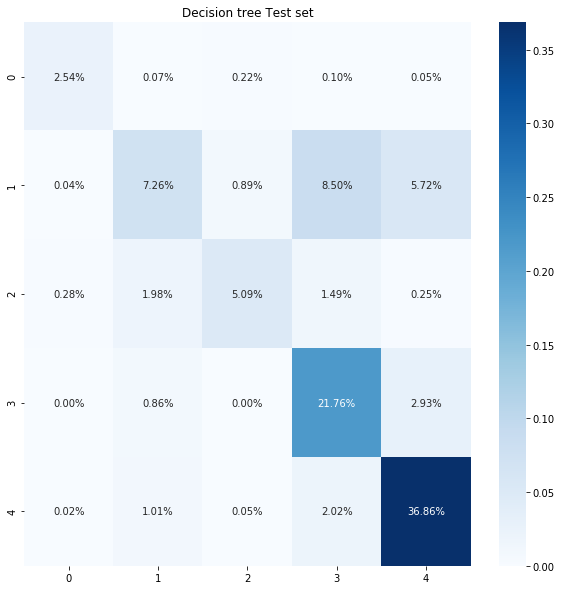

In [97]:
parameters = {
    "max_depth":[12, 14, 15, 16, 17, 18],
    "min_samples_leaf": [ 2, 3, 4, 5],
    'min_samples_split': [2, 5, 10],
    "max_leaf_nodes": [15, 17, 20, 23, 25]
}
decision_tree_model = DecisionTreeClassifier()
grid_search = GridSearchCV(decision_tree_model, param_grid = parameters, scoring = "f1_micro", cv = k_fold)
grid_search.fit(diamonds_features_train, diamonds_labelss_train)
print("Decision tree, best params", grid_search.best_params_)
print("Decision tree, best scoring", grid_search.best_score_)

show_scoring_results("Decision Tree", grid_search)

plot_confusion_matrix(grid_search, diamonds_features_train, diamonds_labelss_train, "Decision tree Test set")

Decision tree, best params {'max_depth': 10, 'max_leaf_nodes': 27, 'min_samples_leaf': 2, 'min_samples_split': 2}
Decision tree, best scoring 0.7343981351686726
Decision Tree F1 micro train score: 0.7371105341246291
Decision Tree F1 micro train score: 0.7306194362017803


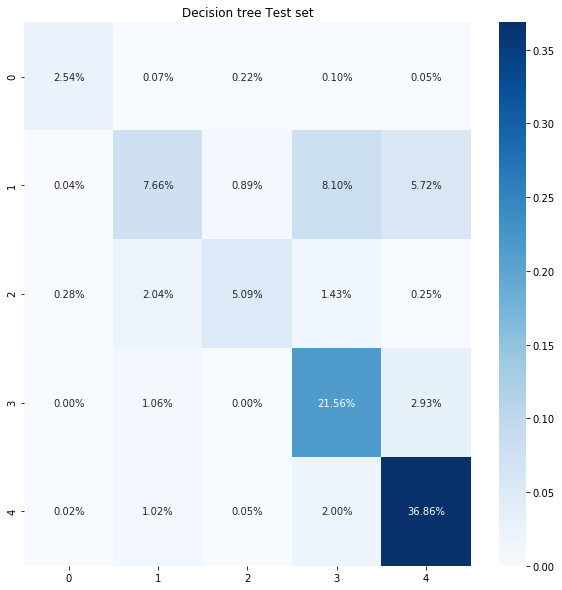

In [98]:
parameters = {
    "max_depth":[10, 11 ,12, 13, 14],
    "min_samples_leaf": [ 2, 3 ],
    'min_samples_split': [2, 5],
    "max_leaf_nodes": [23, 24, 25, 26, 27]
}
decision_tree_model = DecisionTreeClassifier()
grid_search = GridSearchCV(decision_tree_model, param_grid = parameters, scoring = "f1_micro", cv = k_fold)
grid_search.fit(diamonds_features_train, diamonds_labelss_train)
print("Decision tree, best params", grid_search.best_params_)
print("Decision tree, best scoring", grid_search.best_score_)

show_scoring_results("Decision Tree", grid_search)

plot_confusion_matrix(grid_search, diamonds_features_train, diamonds_labelss_train, "Decision tree Train set")

In [109]:
print(classification_report(diamonds_labelss_train, grid_search.predict(diamonds_features_train)))

              precision    recall  f1-score   support

           0       0.88      0.85      0.87      1287
           1       0.65      0.34      0.45      9665
           2       0.81      0.56      0.66      3922
           3       0.65      0.84      0.73     11024
           4       0.80      0.92      0.86     17238

    accuracy                           0.74     43136
   macro avg       0.76      0.70      0.71     43136
weighted avg       0.73      0.74      0.72     43136



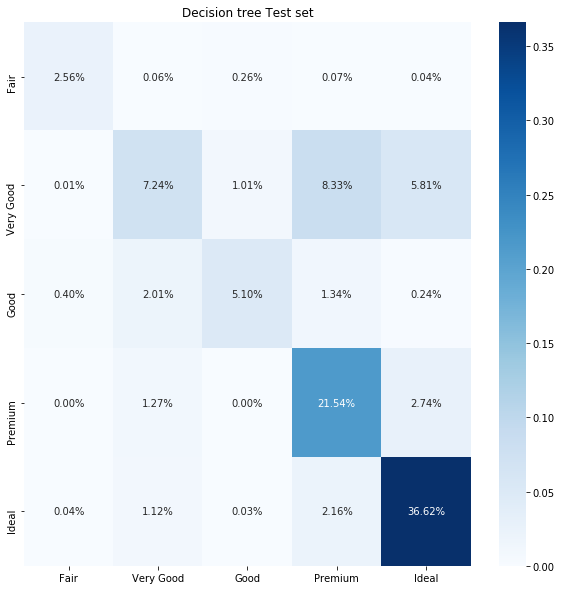

In [107]:
plot_confusion_matrix(grid_search, diamonds_features_test, diamonds_labelss_test, "Decision tree Test set")

In [110]:
print(classification_report(diamonds_labelss_test, grid_search.predict(diamonds_features_test)))

              precision    recall  f1-score   support

           0       0.85      0.86      0.85       322
           1       0.62      0.32      0.42      2416
           2       0.80      0.56      0.66       980
           3       0.64      0.84      0.73      2756
           4       0.81      0.92      0.86      4310

    accuracy                           0.73     10784
   macro avg       0.74      0.70      0.71     10784
weighted avg       0.72      0.73      0.71     10784



## Random Forest

In [71]:
parameters = {
    "n_estimators": [100, 200, 300] ,
    "max_depth": [20, 50, 100]
}
random_forest_model = RandomForestClassifier()
grid_search = GridSearchCV(random_forest_model, param_grid = parameters, scoring = "f1_micro", cv = k_fold)
grid_search.fit(diamonds_features_train, diamonds_labelss_train)
print("Random Forest, best params", grid_search.best_params_)

Random Forest, best params {'max_depth': 100, 'n_estimators': 300}
Random Forest; best score: 0.7668999882257721


In [72]:
show_scoring_results("Random Forest", grid_search)

Random Forest train Accuracy: 0.999884087537092
Random Forest test Accuracy: 0.7671550445103856
Random Forest F1 weighted train score: 0.999884087537092
Random Forest F1 weighted test score: 0.7671550445103856


Random Forest, best params {'max_depth': 100, 'min_samples_split': 5, 'n_estimators': 600}
Random Forest F1 micro train score: 0.966825853115727
Random Forest F1 micro train score: 0.7725333827893175


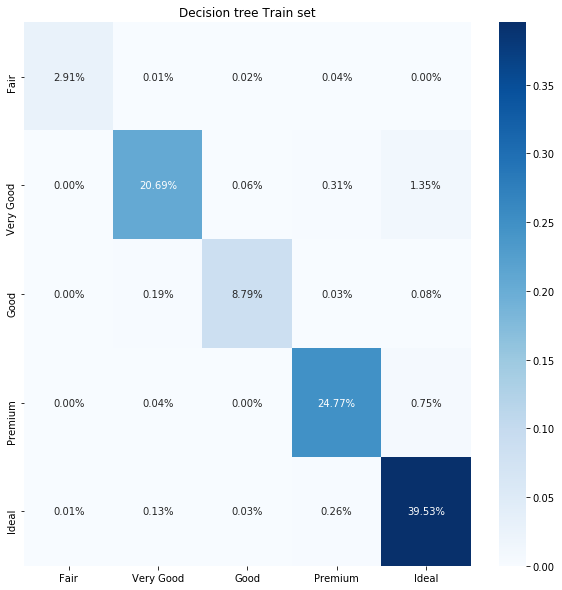

In [111]:
parameters = {
     'max_depth': [80, 100, 120],
     'min_samples_split': [2, 5, 10],
     'n_estimators': [200, 300, 400, 600]
}
random_forest_model = RandomForestClassifier()
grid_search = GridSearchCV(random_forest_model, param_grid = parameters, scoring = "f1_micro", cv = k_fold)
grid_search.fit(diamonds_features_train, diamonds_labelss_train)
print("Random Forest, best params", grid_search.best_params_)

show_scoring_results("Random Forest", grid_search)
plot_confusion_matrix(grid_search, diamonds_features_train, diamonds_labelss_train, "Decision tree Train set")

In [ ]:
print(classification_report(diamonds_labelss_train, grid_search.predict(diamonds_features_train)))

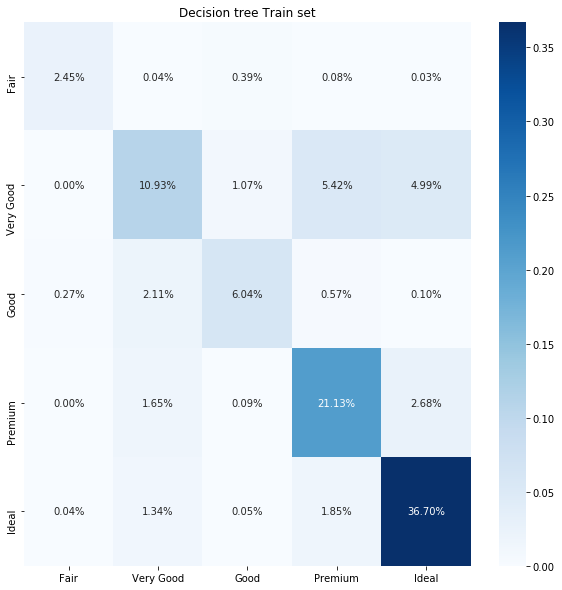

In [112]:
plot_confusion_matrix(grid_search, diamonds_features_test, diamonds_labelss_test, "Decision tree Train set")

## Gaussian SVM

In [74]:
parameters = {
    "C" : [10, 15, 20, 50, 200],
    "gamma": [0.001, 0.01, 0.1, 0.2]
}
gausian_svm_model = SVC()
grid_search = GridSearchCV(gausian_svm_model, param_grid = parameters, scoring = "f1_micro", cv = k_fold)
grid_search.fit(diamonds_features_train, diamonds_labelss_train)
print("Gausian SVM, best params", grid_search.best_params_)

Gausian SVM, best params {'C': 50, 'gamma': 0.1}
Gausian SVM; best score: 0.7703541414731241


In [75]:
show_scoring_results("Gausian SVC", grid_search)

Gausian SVC train Accuracy: 0.8071912091988132
Gausian SVC test Accuracy: 0.773089762611276
Gausian SVC F1 micro train score: 0.8071912091988132
Gausian SVC F1 micro test score: 0.773089762611276


In [76]:
parameters = {
    "C" : [ 30, 40, 50, 60, 70],
    "gamma": [0.05, 0.1, 0.15, ]
}
gausian_svm_model = SVC()
grid_search = GridSearchCV(gausian_svm_model, param_grid = parameters, scoring = "f1_micro", cv = k_fold)
grid_search.fit(diamonds_features_train, diamonds_labelss_train)
print("Gausian SVM, best params", grid_search.best_params_)

Gausian SVM, best params {'C': 50, 'gamma': 0.1}
Gausian SVM; best score: 0.7703541414731241


In [77]:
show_scoring_results("Gausian SVC", grid_search)

Gausian SVC train Accuracy: 0.8071912091988132
Gausian SVC test Accuracy: 0.773089762611276
Gausian SVC F1 micro train score: 0.8071912091988132
Gausian SVC F1 micro test score: 0.773089762611276


In [78]:
parameters = {
    "C" : [ 47, 48, 49, 50, 51, 52, 53],
    "gamma": [0.05, 0.075, 0.1, 0.125,0.15 ]
}
gausian_svm_model = SVC()
grid_search = GridSearchCV(gausian_svm_model, param_grid = parameters, scoring = "f1_micro", cv = k_fold)
grid_search.fit(diamonds_features_train, diamonds_labelss_train)
print("Gausian SVM, best params", grid_search.best_params_)
show_scoring_results("Gausian SVC", grid_search)

Gausian SVM, best params {'C': 50, 'gamma': 0.075}
Gausian SVM; best score: 0.7708178128213764
Gausian SVC train Accuracy: 0.8000510014836796
Gausian SVC test Accuracy: 0.7729043026706232
Gausian SVC F1 micro train score: 0.8000510014836796
Gausian SVC F1 micro test score: 0.7729043026706232


## Liera SVM

In [79]:
parameters = {
    "C" : [0.1, 0.5, 0.8, 1, 1.5, 2, 6, 10, 15, 20]
}
linear_svm_model = LinearSVC()
grid_search = GridSearchCV(linear_svm_model, param_grid = parameters, scoring = "f1_micro", cv = k_fold)
grid_search.fit(diamonds_features_train, diamonds_labelss_train)
print("Linear SVM, best params", grid_search.best_params_)
show_scoring_results("Linear SVC", grid_search)

Linear SVM, best params {'C': 10}
Linear SVC train Accuracy: 0.6310969955489614
Linear SVC test Accuracy: 0.6336238872403561
Linear SVC F1 micro train score: 0.6310969955489614
Linear SVC F1 micro test score: 0.6336238872403561
